# Training simple neural networks on the MNIST dataset using keras

You can create a suitable conda environment to run this notebook using:

    conda create -n keras_demo python=3 tensorflow matplotlib ipykernel scikit-learn pandas
    
If you haven't got the latest cuda drivers, you may also need to specify `cudatoolkit=9.0` or similar.

### First some common imports...

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd

### Set up TensorFlow in a friendly manner

In [2]:
import tensorflow as tf

# if multiple GPUs, only use one of them 
import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"

# avoid hogging all the GPU memory
config = tf.ConfigProto()
config.gpu_options.allow_growth=True
sess = tf.Session(config=config)

In [3]:
# check that we have the devices we expect available
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 16422222170145712565]

### Import keras bits and pieces

In [4]:
# if you have a recent version of tensorflow, keras is included
from tensorflow import keras
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (Dense, Dropout, Conv2D, Flatten,
                                     AveragePooling2D, MaxPooling2D)
from tensorflow.keras.optimizers import RMSprop

### We will use a standard demonstration data set: MNIST handwritten digits

In [5]:
# the data, split between train and test sets
(x_train, y_train), (x_valtest, y_valtest) = mnist.load_data()

In [6]:
# demo the effect of noisy data
#x_train = (x_train/5 + np.random.poisson(200, size=x_train.shape)).clip(0, 255)
#x_valtest = (x_valtest/5 + np.random.poisson(200, size=x_valtest.shape)).clip(0, 255)

In [7]:
# if we wanted to test our model on limited data,
# we could reduce the amount of training data like this...
idx = np.random.choice(len(x_train), size=len(x_train)//100)
x_train = x_train[idx]
y_train = y_train[idx]

If your data isn't split, or want a validation set, need to do split manually

In [8]:
from sklearn.model_selection import train_test_split
x_test, x_val, y_test, y_val = train_test_split(x_valtest, y_valtest, test_size=0.5)

In [9]:
x_train.shape, y_train.shape

((600, 28, 28), (600,))

In [10]:
x_test.shape, y_test.shape

((5000, 28, 28), (5000,))

In [11]:
x_val.shape, y_val.shape

((5000, 28, 28), (5000,))

### Take a look at the data

This is a very quick glance - you should carefully examine any new dataset

class = 8


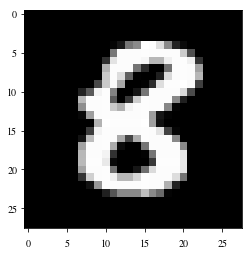

In [12]:
i = 3
plt.imshow(x_train[i], cmap='gray')
print('class =', y_train[i])

### Prepare the data

In [13]:
# convert class vectors to "one-hot" binary class matrices
num_classes = 10
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)
y_val = keras.utils.to_categorical(y_val, num_classes)

In [14]:
y_train[i]

array([0., 0., 0., 0., 0., 0., 0., 0., 1., 0.], dtype=float32)

In [15]:
def process_data(x):
    x = x.reshape(-1, 784)
    x = x.astype('float32')
    x /= 255
    return x

In [16]:
x_train = process_data(x_train)
x_test = process_data(x_test)
x_val = process_data(x_val)

In [17]:
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')
print(x_val.shape[0], 'validation samples')

600 train samples
5000 test samples
5000 validation samples


## Constraints

In order to convert to an SNN, we cannot have negative weights (nor initial inputs). We therefore constrain all biases to zero and use activations with only positive outputs. We also use average (rather than max) pooling in the CNN.

In [18]:
from tensorflow.keras.constraints import Constraint
from tensorflow.keras import backend as K

class FixToZero(Constraint):
    """Constrains the bias/weights to be zero.
    """

    def __call__(self, w):
        w *= K.cast(w * 0, K.floatx())
        return w

## Fully-connected NN

### Construct the network

In [19]:
# a fairly small network for speed
fcmodel = Sequential()
fcmodel.add(Dense(32, activation='relu', input_shape=(784,), bias_constraint=FixToZero()))
fcmodel.add(Dense(32, activation='relu', bias_constraint=FixToZero()))
# could include dropout, regularisation, ...
fcmodel.add(Dense(num_classes, activation='softmax', bias_constraint=FixToZero()))

In [20]:
fcmodel.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 32)                25120     
_________________________________________________________________
dense_1 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_2 (Dense)              (None, 10)                330       
Total params: 26,506
Trainable params: 26,506
Non-trainable params: 0
_________________________________________________________________


In [21]:
fcmodel.compile(loss='categorical_crossentropy',
                optimizer=RMSprop(),
                metrics=['accuracy'])

### Train the network

In [22]:
batch_size = 32
epochs = 50

In [23]:
history = fcmodel.fit(x_train, y_train,
                      batch_size=batch_size,
                      epochs=epochs,
                      verbose=2,
                      validation_data=(x_test, y_test))

Train on 600 samples, validate on 5000 samples
Epoch 1/50
 - 1s - loss: 2.0152 - acc: 0.3467 - val_loss: 1.7143 - val_acc: 0.4992
Epoch 2/50
 - 0s - loss: 1.4827 - acc: 0.5950 - val_loss: 1.3289 - val_acc: 0.6466
Epoch 3/50
 - 0s - loss: 1.1335 - acc: 0.7017 - val_loss: 1.0571 - val_acc: 0.7042
Epoch 4/50
 - 0s - loss: 0.8812 - acc: 0.7800 - val_loss: 0.8867 - val_acc: 0.7672
Epoch 5/50
 - 0s - loss: 0.7208 - acc: 0.8283 - val_loss: 0.7542 - val_acc: 0.8026
Epoch 6/50
 - 0s - loss: 0.5970 - acc: 0.8467 - val_loss: 0.6722 - val_acc: 0.8326
Epoch 7/50
 - 0s - loss: 0.5126 - acc: 0.8767 - val_loss: 0.6109 - val_acc: 0.8344
Epoch 8/50
 - 0s - loss: 0.4340 - acc: 0.8883 - val_loss: 0.5889 - val_acc: 0.8380
Epoch 9/50
 - 0s - loss: 0.3902 - acc: 0.9050 - val_loss: 0.5847 - val_acc: 0.8340
Epoch 10/50
 - 0s - loss: 0.3402 - acc: 0.9167 - val_loss: 0.5210 - val_acc: 0.8530
Epoch 11/50
 - 0s - loss: 0.3027 - acc: 0.9333 - val_loss: 0.5300 - val_acc: 0.8446
Epoch 12/50
 - 0s - loss: 0.2630 - acc

In [24]:
score = fcmodel.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.7566982478842139
Test accuracy: 0.863


In [25]:
# really we should not look at the score for this set of data
# until we have finished tuning our model
score = fcmodel.evaluate(x_val, y_val, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.8195701971463859
Test accuracy: 0.8526


In [26]:
def histplot(history):
    hist = pd.DataFrame(history.history)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    hist.plot(y=['loss', 'val_loss'], ax=ax1)
    min_loss = hist['val_loss'].min()
    ax1.hlines(min_loss, 0, len(hist), linestyle='dotted',
               label='min(val_loss) = {:.3f}'.format(min_loss))
    ax1.legend(loc='upper right')
    hist.plot(y=['acc', 'val_acc'], ax=ax2)
    max_acc = hist['val_acc'].max()
    ax2.hlines(max_acc, 0, len(hist), linestyle='dotted',
               label='max(val_acc) = {:.3f}'.format(max_acc))
    ax2.legend(loc='lower right', fontsize='large')

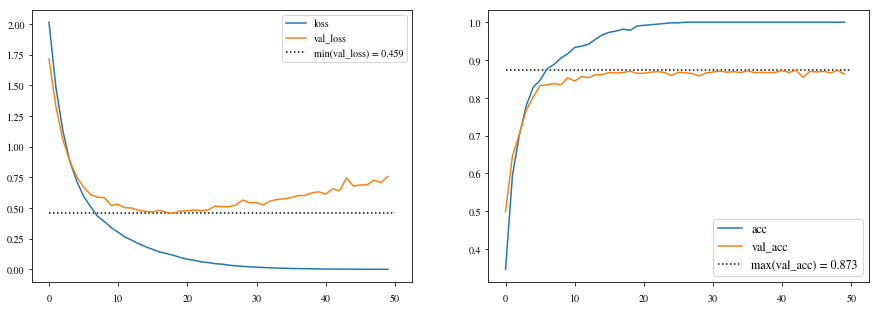

In [27]:
histplot(history)

### Normalise weights for conversion to SNN

In [28]:
def data_based_normalization(model, data):
    # Normalize the weights by Algorithm 2 of Diehl, Neil et al. 2015
    # get max activation in each layer across set of data
    layer_outputs = [layer.output for layer in model.layers] 
    activation_model = Model(inputs=model.input, outputs=layer_outputs)
    activations = activation_model.predict(data)
    max_acts = [a.max() for a in activations]
    # get current max weight in each layer
    weights = model.get_weights()[::2]  # skip over biases
    max_wts = [l.max() for l in weights]
    previous_factor = 1.0
    for layer, (max_wt, max_act) in enumerate(zip(max_wts, max_acts)):
        scale_factor = max(max_wt, max_act)
        applied_factor = scale_factor / previous_factor
        weights[layer] /= applied_factor
        print(max_wt, max_act)
        print('Rescaling weights of layer {} by factor {}'.format(layer+1, 1/applied_factor))
        previous_factor = scale_factor
    return weights

In [29]:
snn_fcn_weights = data_based_normalization(fcmodel, x_train)

0.47021794 15.394342
Rescaling weights of layer 1 by factor 0.06495892923229872
0.6206441 24.576706
Rescaling weights of layer 2 by factor 0.6263793833671739
0.61903554 1.0
Rescaling weights of layer 3 by factor 24.576705770267633


## Convolutional Neural Network (CNN)

### Reshape the data

In [30]:
x_train = x_train.reshape(-1, 28, 28, 1)
x_test = x_test.reshape(-1, 28, 28, 1)

### Construct the network

In [31]:
# a fairly small network for speed
cnnmodel = Sequential()
cnnmodel.add(Conv2D(8, (3, 3), activation='relu', input_shape=(28, 28, 1),
                    bias_constraint=FixToZero()))
cnnmodel.add(AveragePooling2D((3, 3)))
cnnmodel.add(Conv2D(16, (3, 3), activation='relu',
                    bias_constraint=FixToZero()))
cnnmodel.add(AveragePooling2D((2, 2)))
cnnmodel.add(Flatten())
cnnmodel.add(Dense(num_classes, activation='softmax',
                   bias_constraint=FixToZero()))
# could include dropout, regularisation, ...

In [32]:
cnnmodel.compile(loss='categorical_crossentropy',
                optimizer=RMSprop(),
                metrics=['accuracy'])

In [33]:
cnnmodel.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 8)         80        
_________________________________________________________________
average_pooling2d (AveragePo (None, 8, 8, 8)           0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 6, 6, 16)          1168      
_________________________________________________________________
average_pooling2d_1 (Average (None, 3, 3, 16)          0         
_________________________________________________________________
flatten (Flatten)            (None, 144)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 10)                1450      
Total params: 2,698
Trainable params: 2,698
Non-trainable params: 0
_________________________________________________________________


In [34]:
# save weights for reinitialising below
cnnmodel.save_weights('/tmp/cnnmodel_init_weights.tf')


Consider using a TensorFlow optimizer from `tf.train`.


### Train the network

In [35]:
history = cnnmodel.fit(x_train, y_train,
                       batch_size=batch_size, 
                       epochs=3*epochs,
                       verbose=2,
                       validation_data=(x_test, y_test))

Train on 600 samples, validate on 5000 samples
Epoch 1/150
 - 2s - loss: 2.2703 - acc: 0.1383 - val_loss: 2.2303 - val_acc: 0.1788
Epoch 2/150
 - 0s - loss: 2.1592 - acc: 0.2867 - val_loss: 2.1059 - val_acc: 0.3108
Epoch 3/150
 - 1s - loss: 1.9900 - acc: 0.4400 - val_loss: 1.9034 - val_acc: 0.4562
Epoch 4/150
 - 1s - loss: 1.7599 - acc: 0.5567 - val_loss: 1.6415 - val_acc: 0.5828
Epoch 5/150
 - 1s - loss: 1.4980 - acc: 0.6433 - val_loss: 1.3982 - val_acc: 0.6348
Epoch 6/150
 - 1s - loss: 1.2663 - acc: 0.6717 - val_loss: 1.1954 - val_acc: 0.6688
Epoch 7/150
 - 1s - loss: 1.0858 - acc: 0.7033 - val_loss: 0.9884 - val_acc: 0.7394
Epoch 8/150
 - 0s - loss: 0.9450 - acc: 0.7383 - val_loss: 0.9056 - val_acc: 0.7288
Epoch 9/150
 - 1s - loss: 0.8522 - acc: 0.7483 - val_loss: 0.7900 - val_acc: 0.7664
Epoch 10/150
 - 1s - loss: 0.7807 - acc: 0.7700 - val_loss: 0.7525 - val_acc: 0.7748
Epoch 11/150
 - 0s - loss: 0.7262 - acc: 0.7817 - val_loss: 0.7302 - val_acc: 0.7714
Epoch 12/150
 - 0s - loss: 

Epoch 97/150
 - 0s - loss: 0.1053 - acc: 0.9733 - val_loss: 0.3952 - val_acc: 0.8998
Epoch 98/150
 - 0s - loss: 0.0974 - acc: 0.9683 - val_loss: 0.4359 - val_acc: 0.8880
Epoch 99/150
 - 0s - loss: 0.0942 - acc: 0.9767 - val_loss: 0.4335 - val_acc: 0.8900
Epoch 100/150
 - 0s - loss: 0.0919 - acc: 0.9717 - val_loss: 0.4057 - val_acc: 0.9000
Epoch 101/150
 - 0s - loss: 0.0880 - acc: 0.9767 - val_loss: 0.4255 - val_acc: 0.8910
Epoch 102/150
 - 0s - loss: 0.0870 - acc: 0.9817 - val_loss: 0.4259 - val_acc: 0.8944
Epoch 103/150
 - 0s - loss: 0.0911 - acc: 0.9700 - val_loss: 0.4220 - val_acc: 0.8964
Epoch 104/150
 - 0s - loss: 0.0823 - acc: 0.9733 - val_loss: 0.4378 - val_acc: 0.8950
Epoch 105/150
 - 0s - loss: 0.0818 - acc: 0.9833 - val_loss: 0.4394 - val_acc: 0.8910
Epoch 106/150
 - 0s - loss: 0.0824 - acc: 0.9750 - val_loss: 0.4165 - val_acc: 0.8984
Epoch 107/150
 - 0s - loss: 0.0777 - acc: 0.9817 - val_loss: 0.4413 - val_acc: 0.8906
Epoch 108/150
 - 0s - loss: 0.0802 - acc: 0.9717 - val_lo

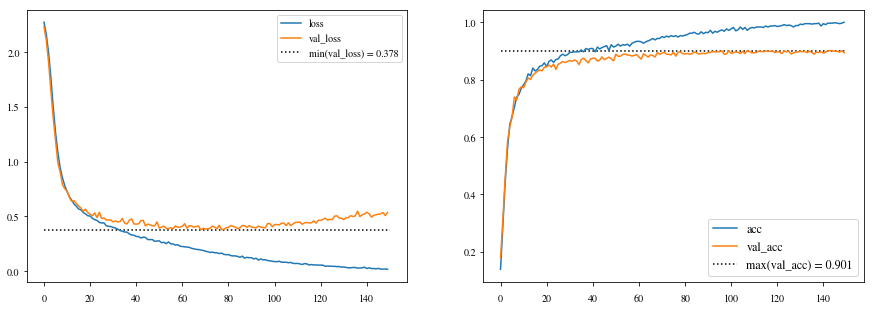

In [36]:
histplot(history)

In [37]:
snn_cnn_weights = data_based_normalization(cnnmodel, x_train)

1.5517428 8.942634
Rescaling weights of layer 1 by factor 0.11182388114105626
0.44019738 8.942634
Rescaling weights of layer 2 by factor 1.0
0.5908108 41.147625
Rescaling weights of layer 3 by factor 0.2173305043381082
